In [3]:
# Import necessary libraries
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np


import torch
import timm  # Library for pre-trained ViT models
import torch.nn as nn
import torch.nn.functional as F

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


c:\Users\csury\anaconda3\envs\att_distill\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


In [4]:
# Define transformations for training and testing datasets (converting from 32x32 to 224x224)
transform = transforms.Compose([
    transforms.Resize((224, 224), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


# Load CIFAR-100 dataset
train_dataset = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


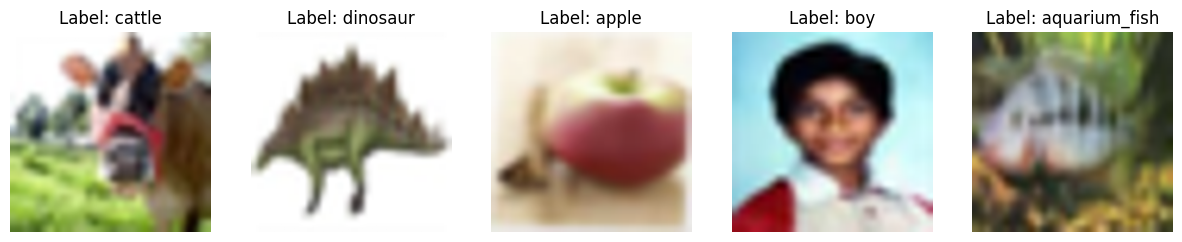

In [4]:
# Function to unnormalize images for visualization
def unnormalize(img):
    img = img * 0.5 + 0.5  # Unnormalize
    return img

# Display a few sample images
classes = train_dataset.classes
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    img, label = train_dataset[i]
    img = unnormalize(img).permute(1, 2, 0).numpy()
    axes[i].imshow(img)
    axes[i].set_title(f"Label: {classes[label]}")
    axes[i].axis('off')
plt.show()


In [5]:

# Check a sample batch shape
for images, labels in train_loader:
    print(f"Batch shape: {images.shape}")
    print(f"Labels shape: {labels.shape}")
    break


Batch shape: torch.Size([64, 3, 224, 224])
Labels shape: torch.Size([64])


### VIT TEACHER MODEL

In [5]:
# Load pre-trained ViT-Small model from timm
vit_model = timm.create_model('vit_small_patch16_224', pretrained=True)
vit_model.to(device)
vit_model.eval()  # Set to evaluation mode

# Print model architecture (optional)
print(vit_model)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [6]:
# Modify the classifier head for CIFAR-100 (100 classes)
num_classes = 100
vit_model.head = nn.Linear(vit_model.head.in_features, num_classes)
vit_model.to(device)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [7]:
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (inputs, targets) in enumerate(dataloader):
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
        if batch_idx % 100 == 0:
            print(f'Batch: {batch_idx}, Loss: {running_loss/(batch_idx+1):.3f}, Acc: {100.*correct/total:.3f}%')
    
    return running_loss / len(dataloader), 100. * correct / total

def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    
    return running_loss / len(dataloader), 100. * correct / total



In [9]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(vit_model.parameters(), lr=1e-4, weight_decay=0.05)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# Training loop
num_epochs = 10
best_acc = 0.0
train_losses, train_accs = [], []
test_losses, test_accs = [], []

for epoch in range(num_epochs):
    print(f'Epoch: {epoch+1}/{num_epochs}')
    
    # Train
    train_loss, train_acc = train_one_epoch(vit_model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # Evaluate
    test_loss, test_acc = evaluate(vit_model, test_loader, criterion, device)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')
    
    # Save best model
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(vit_model.state_dict(), 'vit_best_model.pth')
        print(f'Saved best model with accuracy: {best_acc:.2f}%')
    
    # Update learning rate
    scheduler.step()

print(f'Best test accuracy: {best_acc:.2f}%')


Epoch: 1/10
Batch: 0, Loss: 5.949, Acc: 0.000%
Batch: 100, Loss: 2.030, Acc: 53.852%
Batch: 200, Loss: 1.369, Acc: 67.475%
Batch: 300, Loss: 1.115, Acc: 72.638%
Batch: 400, Loss: 0.981, Acc: 75.335%
Batch: 500, Loss: 0.885, Acc: 77.295%
Batch: 600, Loss: 0.821, Acc: 78.564%
Batch: 700, Loss: 0.772, Acc: 79.636%
Train Loss: 0.7405, Train Acc: 80.31%
Test Loss: 0.4782, Test Acc: 85.86%
Saved best model with accuracy: 85.86%
Epoch: 2/10
Batch: 0, Loss: 0.258, Acc: 92.188%
Batch: 100, Loss: 0.247, Acc: 92.311%
Batch: 200, Loss: 0.255, Acc: 92.079%
Batch: 300, Loss: 0.255, Acc: 92.104%
Batch: 400, Loss: 0.262, Acc: 91.856%
Batch: 500, Loss: 0.267, Acc: 91.723%
Batch: 600, Loss: 0.268, Acc: 91.673%
Batch: 700, Loss: 0.271, Acc: 91.632%
Train Loss: 0.2712, Train Acc: 91.65%
Test Loss: 0.4419, Test Acc: 86.96%
Saved best model with accuracy: 86.96%
Epoch: 3/10
Batch: 0, Loss: 0.136, Acc: 95.312%
Batch: 100, Loss: 0.120, Acc: 96.380%
Batch: 200, Loss: 0.121, Acc: 96.276%
Batch: 300, Loss: 0.127

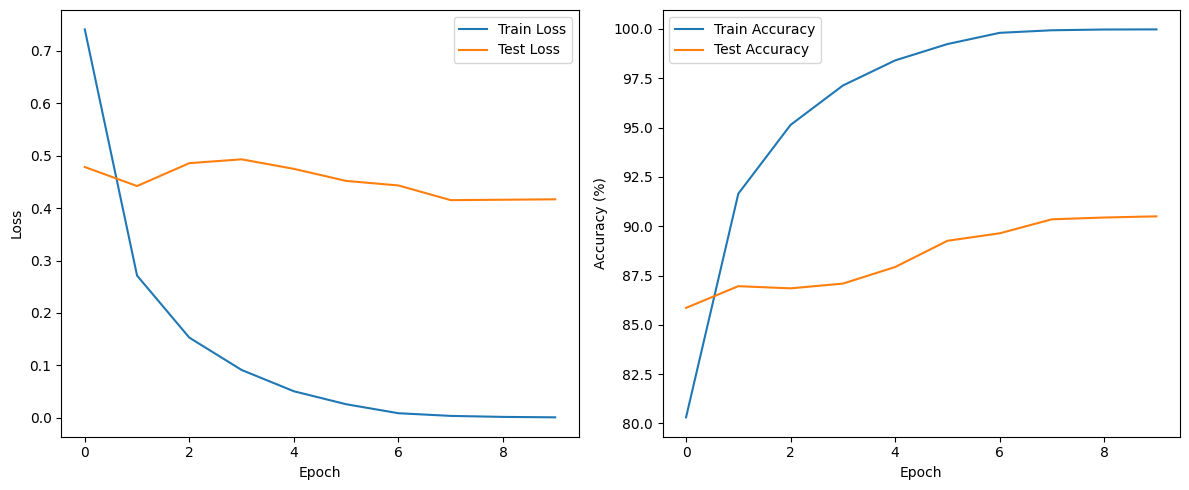

In [10]:
# Plot training curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.savefig('vit_training_curves.png')
plt.show()


In [8]:
# def get_attention_maps(model, x):
#     attention_maps = []
    
#     def hook_fn(module, input, output):
#         # Print the type and shape of output to understand its structure
#         print(f"Output type: {type(output)}, shape: {output.shape if isinstance(output, torch.Tensor) else [o.shape for o in output]}")
        
#         # For timm's ViT implementation, attention weights might be stored differently
#         if isinstance(output, tuple) and len(output) > 1:
#             attention_maps.append(output[1])
#         else:
#             # If output is a single tensor, it might be the attention weights directly
#             attention_maps.append(output)

    
#     # Register hooks on attention blocks
#     hooks = []
#     for block in model.blocks:
#         hooks.append(block.attn.register_forward_hook(hook_fn))
    
#     # Forward pass
#     with torch.no_grad():
#         _ = model(x)
    
#     # Remove hooks
#     for hook in hooks:
#         hook.remove()
    
#     return attention_maps



def get_attention_maps(model, x):
    attention_maps = []
    
    # Define a hook to capture attention maps
    def hook_fn(module, input, output):
        # Print the output type and shape to understand its structure
        if isinstance(output, tuple):
            print(f"Output is a tuple with {len(output)} elements")
            for i, o in enumerate(output):
                if isinstance(o, torch.Tensor):
                    print(f"  Element {i} shape: {o.shape}")
        else:
            print(f"Output is a tensor with shape {output.shape}")
        
        # For timm's ViT implementation, we need to access the attention weights differently
        # They're often stored as an attribute of the module after forward pass
        if hasattr(module, 'attn'):
            attn = module.attn
            if isinstance(attn, torch.Tensor):
                attention_maps.append(attn.detach())
        
        # If we can't find attention weights as an attribute, try to extract from the output
        # This is a fallback and may need adjustment based on the specific model
        if len(attention_maps) == 0 and isinstance(output, torch.Tensor):
            # Just store the output tensor itself for inspection
            attention_maps.append(output.detach())
    
    # Register hooks on attention blocks
    hooks = []
    for name, module in model.named_modules():
        if 'attn' in name and not any(x in name for x in ['attn_drop', 'proj']):
            hooks.append(module.register_forward_hook(hook_fn))
    
    # Forward pass
    with torch.no_grad():
        _ = model(x)
    
    # Remove hooks
    for hook in hooks:
        hook.remove()
    
    return attention_maps






# def visualize_attention_map(attention_map, save_path=None):
#     # Select the first image's first head attention map for visualization
#     # Expected shape: (batch_size, num_heads, num_patches, num_patches)
#     attention_map = attention_map[0, 0].detach().cpu().numpy()
    
#     plt.figure(figsize=(10, 8))
    
#     # If the attention map shape is 1D, try to reshape it to a square
#     if len(attention_map.shape) == 1:
#         size = int(np.sqrt(attention_map.shape[0]))
#         if size * size == attention_map.shape[0]:
#             attention_map = attention_map.reshape(size, size)
#             plt.imshow(attention_map, cmap='viridis')
#             plt.colorbar()
#             plt.title(f"Attention Map ({size}x{size} Patches)")
#         else:
#             # If it's not a perfect square, plot as 1D
#             plt.plot(attention_map)
#             plt.title("Attention Weights (1D)")
#     else:
#         plt.imshow(attention_map, cmap='viridis')
#         plt.colorbar()
#         plt.title(f"Attention Map ({attention_map.shape[0]}x{attention_map.shape[1]} Patches)")
    
#     if save_path:
#         plt.savefig(save_path)
#     plt.show()






def visualize_attention_map(attention_map, save_path=None):
    # Convert to numpy for visualization
    if isinstance(attention_map, torch.Tensor):
        attention_map = attention_map.cpu().numpy()
    
    # Print the shape to understand what we're working with
    print(f"Attention map shape: {attention_map.shape}")
    
    # Handle different attention map shapes
    if len(attention_map.shape) == 4:  # [batch_size, num_heads, seq_len, seq_len]
        # Select first batch and average over heads
        attention_map = attention_map[0].mean(0)
    elif len(attention_map.shape) == 3:  # [batch_size, seq_len, seq_len] or similar
        attention_map = attention_map[0]
    elif len(attention_map.shape) == 2:  # Already in the right format
        pass
    elif len(attention_map.shape) == 1:  # 1D array
        # Try to reshape to a square if possible
        size = int(np.sqrt(attention_map.shape[0]))
        if size * size == attention_map.shape[0]:
            attention_map = attention_map.reshape(size, size)
    
    # Visualize
    plt.figure(figsize=(10, 8))
    plt.imshow(attention_map, cmap='viridis')
    plt.colorbar()
    plt.title(f"Attention Map ({attention_map.shape[0]}x{attention_map.shape[1]} Patches)")
    
    if save_path:
        plt.savefig(save_path)
    plt.show()


C:\Users\csury\AppData\Local\Temp\ipykernel_8156\334226387.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vit_model.load_state_dict(torch.load('vit_best_model.pth'))
Cl

Output is a tensor with shape torch.Size([1, 197, 1152])
Output is a tensor with shape torch.Size([1, 6, 197, 64])
Output is a tensor with shape torch.Size([1, 6, 197, 64])
Output is a tensor with shape torch.Size([1, 197, 384])
Output is a tensor with shape torch.Size([1, 197, 1152])
Output is a tensor with shape torch.Size([1, 6, 197, 64])
Output is a tensor with shape torch.Size([1, 6, 197, 64])
Output is a tensor with shape torch.Size([1, 197, 384])
Output is a tensor with shape torch.Size([1, 197, 1152])
Output is a tensor with shape torch.Size([1, 6, 197, 64])
Output is a tensor with shape torch.Size([1, 6, 197, 64])
Output is a tensor with shape torch.Size([1, 197, 384])
Output is a tensor with shape torch.Size([1, 197, 1152])
Output is a tensor with shape torch.Size([1, 6, 197, 64])
Output is a tensor with shape torch.Size([1, 6, 197, 64])
Output is a tensor with shape torch.Size([1, 197, 384])
Output is a tensor with shape torch.Size([1, 197, 1152])
Output is a tensor with sha

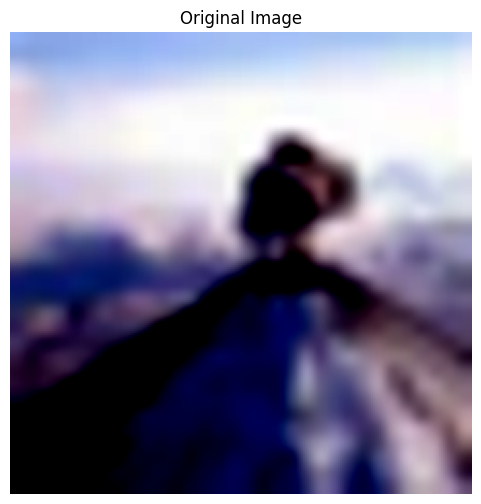

Attention map shape: (1, 197, 1152)


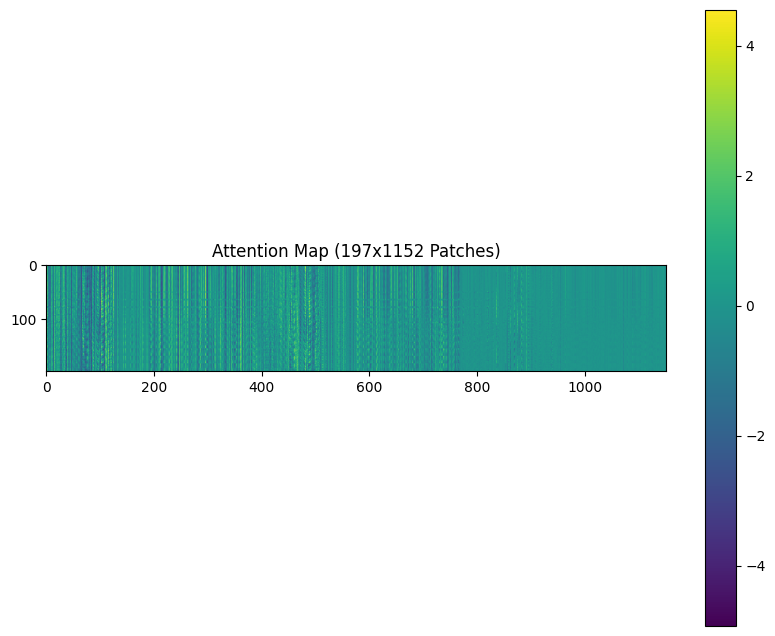

Attention map shape: (1, 197, 1152)


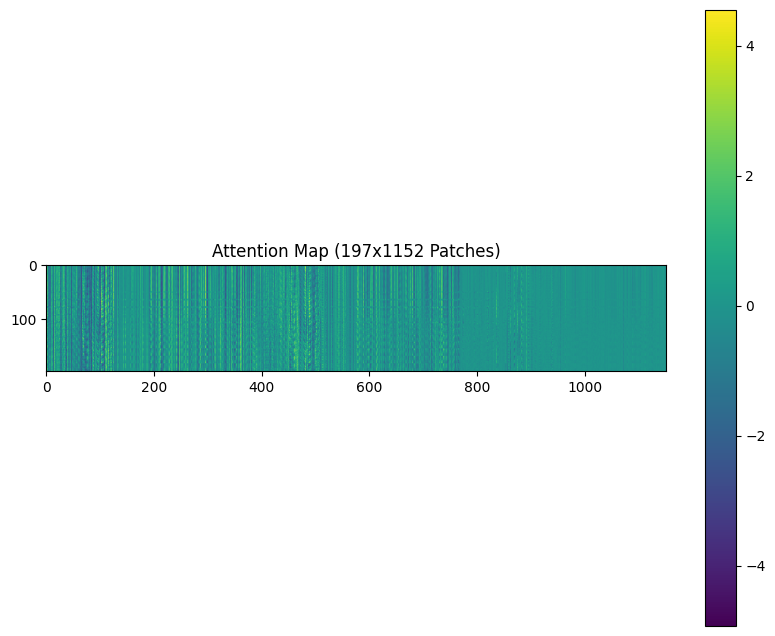

Attention map shape: (1, 197, 1152)


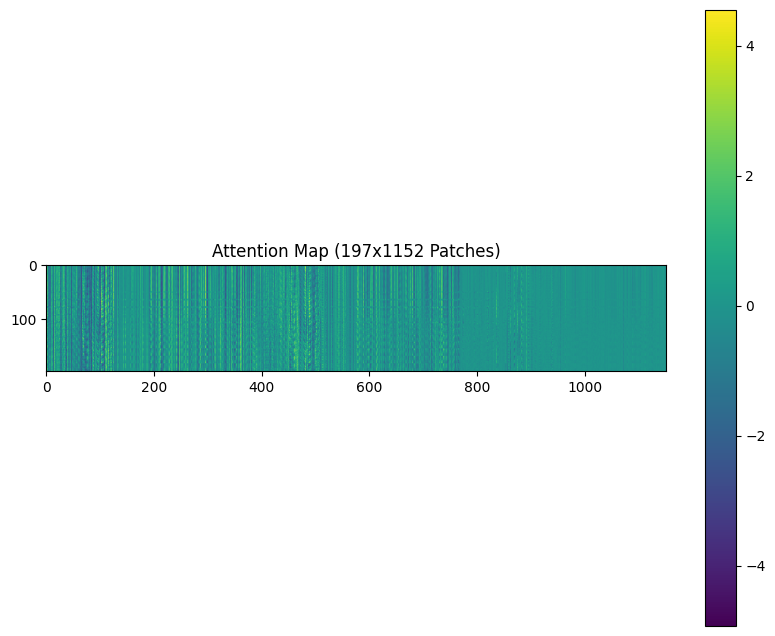

In [10]:
def visualize_model_attention():
    # Load the best model
    vit_model.load_state_dict(torch.load('vit_best_model.pth'))
    vit_model.eval()
    
    # Get a batch of test images
    dataiter = iter(test_loader)
    images, _ = next(dataiter)
    
    # Select a single image
    img = images[0].unsqueeze(0).to(device)
    
    # Get attention maps
    attention_maps = get_attention_maps(vit_model, img)
    
    # Display the original image
    plt.figure(figsize=(6, 6))
    plt.imshow(np.transpose(images[0].cpu().numpy(), (1, 2, 0)))
    plt.title("Original Image")
    plt.axis('off')
    plt.savefig('original_image.png')
    plt.show()
    
    # Visualize attention maps from different layers
    for i, attn_map in enumerate([attention_maps[0], attention_maps[len(attention_maps)//2], attention_maps[-1]]):
        layer_name = "Early" if i == 0 else "Middle" if i == 1 else "Deep"
        visualize_attention_map(attn_map, save_path=f'attention_map_{layer_name}.png')


# Call the visualization function after training
visualize_model_attention()


### DISTILLATION

In [6]:
# Function to extract attention maps using hooks
def get_attention_maps(model, x):
    attention_maps = []

    # Define a hook to capture attention maps
    def hook(module, input, output):
        # Extract only attention weights (not key or query values)
        attention_maps.append(output)

    # Register hooks on all attention layers
    handles = [layer.attn.register_forward_hook(hook) for layer in model.blocks]

    # Forward pass to extract attention maps
    with torch.no_grad():
        _ = model(x)

    # Remove hooks after extraction
    for handle in handles:
        handle.remove()

    return attention_maps


In [7]:
# Function to compute entropy for attention maps
def compute_entropy(attention_map):
    epsilon = 1e-10  # Small value to avoid log(0)
    # Flatten the map and compute probabilities
    attention_map = attention_map.view(attention_map.size(0), -1)  # Flatten spatial dimensions
    attention_map = F.softmax(attention_map, dim=-1)  # Convert to probabilities
    # Compute entropy
    entropy = -torch.sum(attention_map * torch.log(attention_map + epsilon), dim=-1)
    return entropy.mean().item()  # Return average entropy

In [8]:
# Function to compute dynamic layer weights based on entropy (assigning higher weight to lower entropy layers)
def get_layer_weights(attention_maps):
    entropies = [compute_entropy(attn) for attn in attention_maps]
    total_entropy = sum(entropies)
    # Compute weights inversely proportional to entropy
    layer_weights = [(total_entropy - ent) / total_entropy for ent in entropies]
    return layer_weights


In [9]:
# Get a sample batch from train_loader
images, labels = next(iter(train_loader))
images = images.to(device)

# Extract attention maps
attention_maps = get_attention_maps(vit_model, images)
print(f"Extracted {len(attention_maps)} attention maps")

# Compute dynamic weights based on entropy
layer_weights = get_layer_weights(attention_maps)
print(f"Layer Weights: {layer_weights}")


Extracted 12 attention maps
Layer Weights: [0.9116312497670347, 0.9122048151701746, 0.9113335614416844, 0.9114178538506885, 0.9114534362399753, 0.9113035359617032, 0.9115296204066548, 0.9115724328346158, 0.9117732386417313, 0.9124589794197782, 0.9147687458692016, 0.9685525303967576]


Attention map shape: (197, 384)


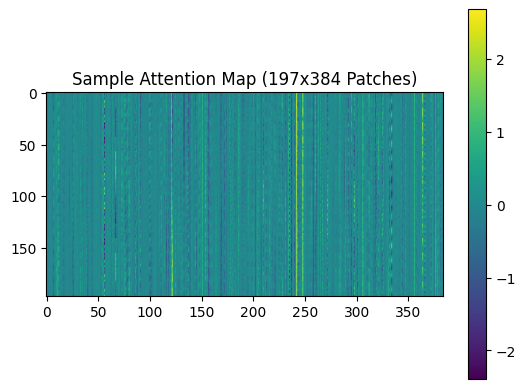

In [11]:
# Visualize a sample attention map
def visualize_attention_map(attention_map):
    # Get the attention map and convert to numpy
    attention_map = attention_map[0].detach().cpu().numpy()
    
    # Print the shape to understand what we're working with
    print("Attention map shape:", attention_map.shape)
    
    # If it's a 1D array, try to reshape it to a square
    if len(attention_map.shape) == 1:
        # Calculate the side length assuming it's a flattened square matrix
        side_length = int(np.sqrt(attention_map.shape[0]))
        
        # Check if we can reshape it to a square
        if side_length * side_length == attention_map.shape[0]:
            attention_map = attention_map.reshape(side_length, side_length)
            plt.imshow(attention_map, cmap='viridis')
            plt.colorbar()
            plt.title(f"Sample Attention Map ({side_length}x{side_length} Patches)")
            plt.show()
        else:
            # If it's not a perfect square, just visualize as a 1D array
            plt.figure(figsize=(10, 2))
            plt.plot(attention_map)
            plt.title("Attention Weights (1D)")
            plt.colorbar()
            plt.show()
    # If it's already a 2D array, visualize directly
    elif len(attention_map.shape) == 2:
        plt.imshow(attention_map, cmap='viridis')
        plt.colorbar()
        plt.title(f"Sample Attention Map ({attention_map.shape[0]}x{attention_map.shape[1]} Patches)")
        plt.show()
    else:
        print(f"Cannot visualize attention map with shape: {attention_map.shape}")

# Try visualizing with the updated function
visualize_attention_map(attention_maps[0])
